In [ ]:
# YahooFinance
import yfinance as yf
symbol = 'META'

df = yf.download(symbol, period="max", interval="1d")
df.to_csv("META.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import BayesianOptimization

<ipython-input-3-d292747a5cab>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [ ]:
pip install yfinance

In [ ]:
!pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=9abd46568b0d9b4c989b52ccdace5d47d39e6f5b08cf1eaf01e48dc7389f0b57
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

meta = pd.read_csv("META.csv")
meta = meta[2:]
meta = meta.reset_index()
meta = meta.drop(columns=["index"])
# Rename 'Date' column in meta to 'Price', the original column name in the CSV.
meta = meta.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
meta.head()

meta[columns_to_convert] = meta[columns_to_convert].astype(float)
meta['Date'] = pd.to_datetime(meta['Date']) # Convert the 'Date' column to datetime
meta['Volume'] = meta['Volume'].astype(int)
# meta.head() # Uncomment to check the DataFrame structure

df = meta
# Now you can filter using the 'Date' column:
df = df[df['Date']>=pd.Timestamp(2020,1,1)].reset_index().drop(columns=["index"]) # Use pd.Timestamp
df = df[df['Date']<pd.Timestamp(2025,1,31)] # Use pd.Timestamp

In [ ]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,208.795929,208.805877,205.302400,205.780144,12077100
1,2020-01-03,207.691147,209.413027,205.979214,206.238004,11188400
2,2020-01-06,211.602707,211.781855,205.551226,205.730374,17058900
3,2020-01-07,212.060547,213.573421,210.756694,211.821682,14912400
4,2020-01-08,214.210419,215.225638,211.612661,212.000831,13475000


In [ ]:
# prompt: drop the first row

df = df.iloc[1:]
df.tail()


,Date,Close,High,Low,Open,Volume
1272,2025-01-24,646.914429,651.420429,633.636264,635.834321,19065300
1273,2025-01-27,659.293457,663.279901,624.544343,626.053010,28399200
1274,2025-01-28,673.730591,681.973257,658.883754,665.407978,20950100
1275,2025-01-29,675.888672,680.444616,665.078282,674.400006,21377800
1276,2025-01-30,686.389343,710.158175,675.499008,696.200622,29322900


In [ ]:
# prompt: see the missing values

print(df.isnull().sum())


Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Select features and target variable
features = ['High', 'Low', 'Open', 'Volume']
target = 'Close'

# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features + [target]]), columns=features + [target], index=df.index)

# Prepare sequences for LSTM
def create_sequences(data, feature_cols, target_col, time_steps=60):
    np.random.seed(42)
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[feature_cols].iloc[i:i+time_steps].values)
        y.append(data[target_col].iloc[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 60  # Use past 60 days for prediction
X, y = create_sequences(df_scaled, features, target, time_steps)

# Split into training and testing sets(80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)


In [ ]:
!pip install keras-tuner


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch

# Define the model function for tuning
def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('units1', min_value=50, max_value=200, step=50), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])),
        LSTM(hp.Int('units2', min_value=50, max_value=200, step=50), return_sequences=False),
        Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])),
        Dense(25, activation=hp.Choice('activation', ['relu', 'tanh'])),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of different models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='lstm_tuner',
    project_name='stock_prediction'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
best_model.evaluate(X_test, y_test)


Trial 10 Complete [00h 01m 12s]
val_loss: 0.0010860268957912922

Best val_loss So Far: 0.0007973116589710116
Total elapsed time: 00h 27m 29s
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - loss: 0.0167 - val_loss: 0.0018
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 322ms/step - loss: 9.0734e-04 - val_loss: 0.0037
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - loss: 8.5936e-04 - val_loss: 0.0027
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - loss: 7.7870e-04 - val_loss: 0.0011
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - loss: 8.6160e-04 - val_loss: 0.0015
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - loss: 8.3534e-04 - val_loss: 0.0033
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step - loss: 8.5098e-04 - val_loss: 0.0034
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step

0.0009344507125206292

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score

In [ ]:
import numpy as np
# Evaluate the model on the training data
train_predictions =best_model.predict(X_train)
train_predictions_inv = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], train_predictions.reshape(-1, 1)), axis=1))[:, -1]
y_train_inv = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]
# For test data
test_predictions =best_model.predict(X_test)
y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]
predictions_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], test_predictions.reshape(-1, 1)), axis=1))[:, -1]

train_mse = mean_squared_error(y_train_inv, train_predictions_inv)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, train_predictions_inv)

print(f"Training Accuracy (R-squared): {train_r2}")
print(f"Training MSE: {train_mse}")
print(f"Training RMSE: {train_rmse}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step
Training Accuracy (R-squared): 0.9790660223728811
Training MSE: 115.06625930946954
Training RMSE: 10.72689420612833


In [ ]:
import matplotlib.dates as mdates

In [ ]:
import pandas as pd

# Assuming your date column is named 'Date'
df['Date'] = pd.to_datetime(df['Date'])

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step

Evaluation Metrics for Best Model:

                           Metric       Value
0        Mean Squared Error (MSE)  334.047580
1  Root Mean Squared Error (RMSE)   18.276969
2                  R-squared (R2)    0.887958
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step

Best Model - Training Accuracy (R-squared): 0.9790660223728811
Best Model - Training MSE: 115.06625930946954
Best Model - Training RMSE: 10.72689420612833

Best Model - Testing Accuracy (R-squared): 0.8879583793387263
Best Model - Testing MSE: 334.0475804666846
Best Model - Testing RMSE: 18.27696857979147


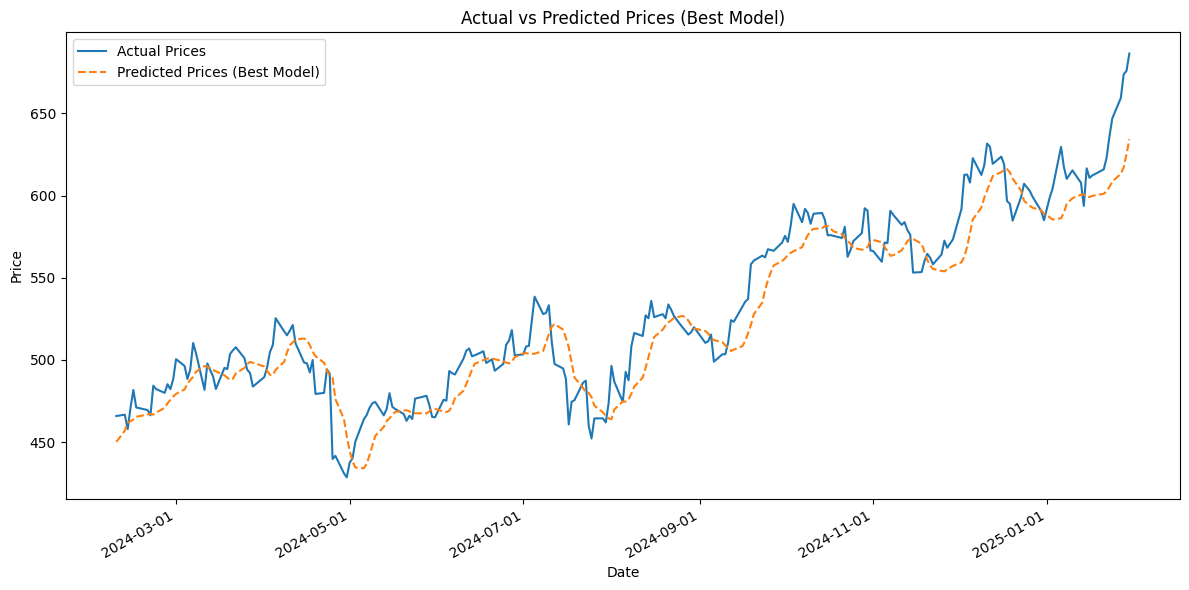

In [ ]:
# prompt: generate the code the error metric just like model2 for my best model as well

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make predictions with the best model
best_predictions = best_model.predict(X_test)

# Inverse transform the predictions to the original scale
best_predictions_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], best_predictions.reshape(-1, 1)), axis=1))[:, -1]

# Calculate evaluation metrics for the best model
best_mse = mean_squared_error(y_test_inv, best_predictions_inv)
best_rmse = np.sqrt(best_mse)
best_r2 = r2_score(y_test_inv, best_predictions_inv)

# Create a table of evaluation metrics for the best model
best_evaluation_metrics = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R-squared (R2)'],
    'Value': [best_mse, best_rmse, best_r2]
})

print("\nEvaluation Metrics for Best Model:\n")
print(best_evaluation_metrics)

# Evaluate the best model on the training data
best_train_predictions = best_model.predict(X_train)
best_train_predictions_inv = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], best_train_predictions.reshape(-1, 1)), axis=1))[:, -1]

best_train_mse = mean_squared_error(y_train_inv, best_train_predictions_inv)
best_train_rmse = np.sqrt(best_train_mse)
best_train_r2 = r2_score(y_train_inv, best_train_predictions_inv)

print(f"\nBest Model - Training Accuracy (R-squared): {best_train_r2}")
print(f"Best Model - Training MSE: {best_train_mse}")
print(f"Best Model - Training RMSE: {best_train_rmse}")

print(f"\nBest Model - Testing Accuracy (R-squared): {best_r2}")
print(f"Best Model - Testing MSE: {best_mse}")
print(f"Best Model - Testing RMSE: {best_rmse}")

#Plot for the best model
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test_inv, label="Actual Prices")
plt.plot(df['Date'].iloc[-len(y_test):], best_predictions_inv, label="Predicted Prices (Best Model)", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.title("Actual vs Predicted Prices (Best Model)")
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


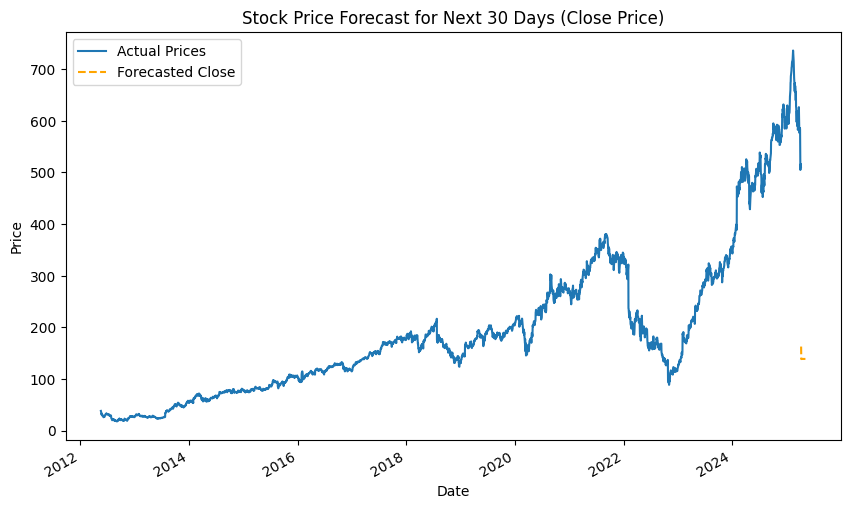

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Select features and target variable
features = ['High','Low', 'Open', 'Volume']
target = 'Close'

# Scale the dataset using the same scaler used during training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(meta[features])

# Get the last data point (from 2024-12-31) to start the forecasting
last_data_point = scaled_data[-1].reshape(1, 1, len(features))

# Initialize a list to store the forecasted prices
forecasted_prices = []

# Forecast for the next 30 days
for i in range(30):
    # Predict the next day's Close price using the trained model
    predicted_close = best_model.predict(last_data_point, verbose=0)[0][0]

    # Append the predicted price to the forecasted prices list
    forecasted_prices.append(predicted_close)

    # Update the last data point for the next prediction
    # Shift the sequence and append the predicted Close value to the features
    last_data_point = np.append(last_data_point[:, 1:, :], [[np.append(scaled_data[-1, 1:], predicted_close)]], axis=1)

# Construct the array for inverse transformation with the forecasted values in the first column
forecast_array = np.zeros((30, len(features)))
forecast_array[:, 0] = forecasted_prices  # Place the forecasted Close in the first column

# Rescale the forecasted prices back to the original scale (reverse transformation)
forecast_rescaled = scaler.inverse_transform(forecast_array)[:, 0]  # Extract the rescaled Close prices

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start=meta['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df = pd.DataFrame(forecast_rescaled, columns=['Predicted Close'], index=forecast_dates)

# Plot the actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(meta['Date'], meta['Close'], label='Actual Prices')
plt.plot(forecast_df.index, forecast_df['Predicted Close'], label='Forecasted Close', linestyle='--', color='orange')
plt.legend()
plt.title("Stock Price Forecast for Next 30 Days (Close Price)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.gcf().autofmt_xdate()
plt.show()


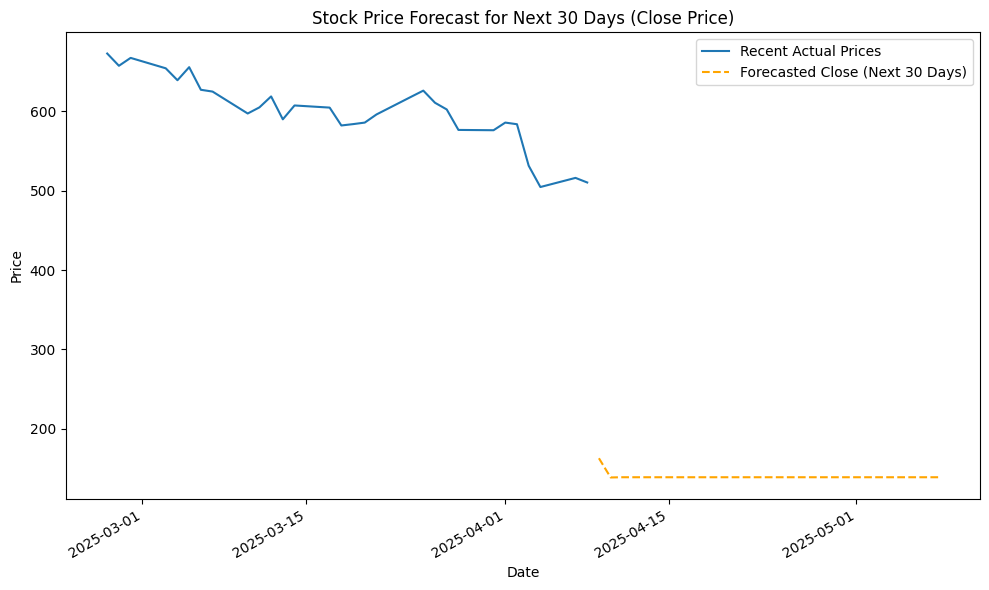

In [ ]:
# Number of past actual days to show before the forecast (optional)
context_days = 30

# Get the last `context_days` of actual data
recent_actual_dates = meta['Date'].iloc[-context_days:]
recent_actual_close = meta['Close'].iloc[-context_days:]

# Plot recent actual data and forecast
plt.figure(figsize=(10, 6))
plt.plot(recent_actual_dates, recent_actual_close, label='Recent Actual Prices')
plt.plot(forecast_df.index, forecast_df['Predicted Close'], label='Forecasted Close (Next 30 Days)', linestyle='--', color='orange')
plt.legend()
plt.title("Stock Price Forecast for Next 30 Days (Close Price)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


In [ ]:
# Model builder for KerasTuner
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        return_sequences = i < hp.get('num_layers') - 1
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                       return_sequences=return_sequences,
                       input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr) if optimizer=='adam' else RMSprop(learning_rate=lr))
    return model

In [ ]:
# Tuner setup
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials= 8,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='stock_lstm')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5)

In [ ]:
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stop, reduce_lr])

Trial 8 Complete [00h 02m 15s]
val_loss: 0.0008532792562618852

Best val_loss So Far: 0.000499263231176883
Total elapsed time: 00h 08m 50s


In [ ]:
# Get best model
best_model_2 = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 7 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model = build_model(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters)
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,
          callbacks=[early_stop, reduce_lr])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1906 - val_loss: 0.2217 - learning_rate: 1.6226e-04
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1045 - val_loss: 0.1290 - learning_rate: 1.6226e-04
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0568 - val_loss: 0.0574 - learning_rate: 1.6226e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0205 - val_loss: 0.0131 - learning_rate: 1.6226e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0059 - val_loss: 0.0046 - learning_rate: 1.6226e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0041 - val_loss: 0.0033 - learning_rate: 1.6226e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0023 - val_loss: 0.0041 - learning_rate: 1.6226e-04
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 0.0030 - learning_rate: 1.6226e-04
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0018 - val_loss: 0.0026 - learning_

In [ ]:
# Evaluate
preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print("Test MSE:", mse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Test MSE: 0.007350876822160925


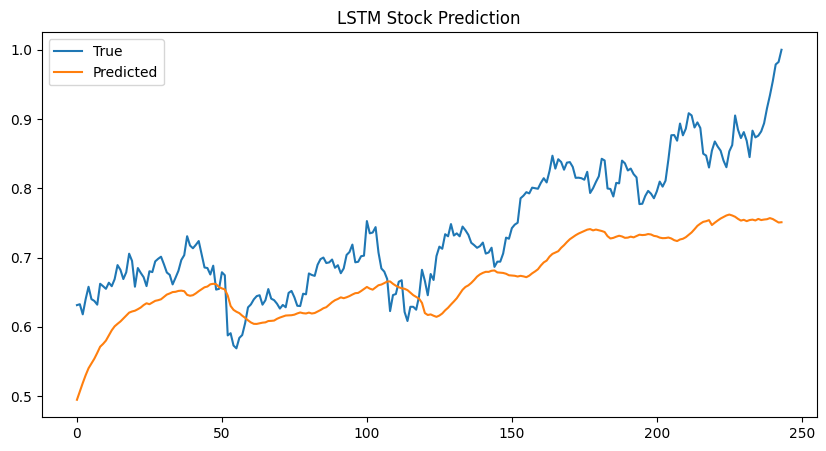

In [ ]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test, label='True')
plt.plot(preds, label='Predicted')
plt.legend()
plt.title('LSTM Stock Prediction')
plt.show()

In [ ]:
from sklearn.metrics import r2_score

# Training R-squared
train_preds = model.predict(X_train)
train_r2 = r2_score(y_train, train_preds)
print(f"Training R-squared: {train_r2}")

test_r2 = r2_score(y_test, preds)
print(f"Testing R-squared: {test_r2}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Training R-squared: 0.9450584491247233
Testing R-squared: 0.11862222123525468
